In [1]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import load_model
from keras import models

Using TensorFlow backend.


In [199]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6295417529801715650
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13717521504129066984
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
import numpy as np
import keras
import warnings
from matplotlib import pyplot as plt
import cv2
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import preprocess_input
import random

In [3]:
def image_process(img,r_size,c_size):
    scaled_image = cv2.resize(img, (r_size, c_size))
    #rot_image = np.rot90(scaled_image,-1)
    return scaled_image

In [4]:
dire = ''
filename = 'yeah2.mov'

In [5]:
def extract_image_data(dire = dire, filename = filename,r_size=224,c_size=224):
    file = dire+ filename
    vidcap = cv2.VideoCapture(file)
    flag = True
    image_list = []
    cnt = 0
    while flag:
        flag,img = vidcap.read()
        if flag:
            image_list += [image_process(img,r_size,c_size)]
            cnt += 1
    return image_list

In [6]:
if False:
    image_list = extract_image_data(dire,filename)
    print(image_list[0].shape)
    print(len(image_list))

In [7]:
if False:
    imgplot = plt.imshow(image_list[0])

In [157]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('./') if isfile(join('./', f)) if f[-3:] == 'mov']

In [160]:
files.sort()
files

['fist.mov',
 'fist1.mov',
 'fist2.mov',
 'five.mov',
 'five2.mov',
 'thumb2.mov',
 'yeah2.mov']

In [193]:
image_dataset = []
category_dataset = []
proj = {}
conv = {}
for filename in files:
    image_list = extract_image_data(dire,filename)
    image_dataset += image_list
    gesture = filename.split('.')[0]
    while not gesture[-1].isalpha():
        gesture = gesture[:-1]
    if gesture not in conv:
        conv[gesture] = len(conv.keys())
    proj[conv[gesture]] = gesture
    category_dataset += [conv[gesture] for _ in image_list]
    print(filename,gesture,conv[gesture],proj[conv[gesture]])
image_dataset = np.asarray(image_dataset)
category_dataset = np.asarray(category_dataset)
category_dataset = keras.utils.to_categorical(category_dataset)

fist.mov fist 0 fist
fist1.mov fist 0 fist
fist2.mov fist 0 fist
five.mov five 1 five
five2.mov five 1 five
thumb2.mov thumb 2 thumb
yeah2.mov yeah 3 yeah


In [175]:
proj

{0: 'fist', 1: 'five', 2: 'thumb', 3: 'yeah'}

In [176]:
conv

{'fist': 0, 'five': 1, 'thumb': 2, 'yeah': 3}

In [177]:
print(image_dataset.shape)
print(category_dataset.shape)

(5094, 224, 224, 3)
(5094, 4)


In [178]:
r_size=224
c_size=224
model = keras.applications.MobileNet(include_top=False,  weights='imagenet', input_shape=(r_size, c_size, 3),  pooling=None)

In [179]:
#print(model.summary())

In [180]:
%%time
processed_input = model.predict(image_dataset)

CPU times: user 17min 27s, sys: 3min 21s, total: 20min 49s
Wall time: 1min 6s


In [200]:
#train-test split
indices = numpy.random.permutation(processed_input.shape[0])
ratio = 0.8
training_idx, test_idx = indices[:int(processed_input.shape[0]*ratio)], indices[int(processed_input.shape[0]*ratio):]
x_train, x_test = processed_input[training_idx,:], processed_input[test_idx,:]
y_train, y_test = category_dataset[training_idx,:], category_dataset[test_idx,:]

In [201]:
print(image_dataset[0].shape)
print(processed_input.shape)

(224, 224, 3)
(5094, 7, 7, 1024)


In [202]:
print(category_dataset.shape)

(5094, 4)


In [210]:
top_model = models.Sequential()
top_model.add(layers.Flatten(input_shape=(7, 7, 1024)))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dense(128, activation='relu'))
#top_model.add(layers.Dropout(0.6))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dropout(0.6))
top_model.add(layers.Dense(64, activation='relu'))
top_model.add(layers.Dense(len(proj), activation='softmax'))

top_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
for _ in range(20):
    top_model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=1,validation_data=(x_test, y_test))
    print(top_model.predict_classes(x_test[_*50:_*50+50]))
    print(np.asarray([sum([int((i)*val[i]) for i in range(4)]) for val in y_test[_*50:_*50+50]]))

In [ ]:
pred = [proj[i] for i in top_model.predict_classes(processed_input)]

In [221]:
#save trained model
from keras.models import load_model

top_model.save('top_model.h5')
del top_model

In [222]:
import json

with open('proj.json', 'w') as fp:
    json.dump(proj, fp)

In [223]:
#load trained model
top_model = load_model('top_model.h5')

In [224]:
def get_command(img,r_size=224,c_size=224):
    scaled_image = cv2.resize(img, (r_size, c_size))
    cmd_id = top_model.predict_classes(model.predict(np.asarray([scaled_image])))[0]
    return cmd_id

fist
CPU times: user 3.52 s, sys: 476 ms, total: 4 s
Wall time: 3.38 s


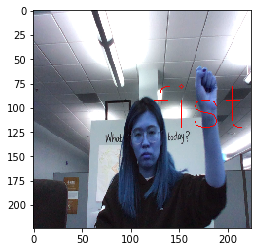

In [225]:
%%time
frame = image_dataset[1200]
cmd_id = get_command(frame)
cmd = proj[cmd_id]
print(cmd)
plt.imshow(cv2.putText(frame,cmd, (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))

In [ ]:
%%time
a = model.predict(np.asarray([cv2.resize(frame, (r_size, c_size))]))

In [ ]:
image_dataset[530].shape

In [ ]:
vidcap = cv2.VideoCapture('yeah2.mov')
flag = True
while flag:
    flag,frame = vidcap.read()
    if flag:
        cmd_id = get_command(frame)
        cmd = proj[cmd_id]
        print(cmd)
        plt.imshow(cv2.putText(frame,cmd, (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))

yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
